In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Check connected GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug 20 01:03:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Create Training & Validation data sets
image_size = (150, 150)
batch_size = 32
class_names = sorted(['storagetanks',  'beach', 'denseresidential', 'freeway', 'parkinglot', 'sparseresidential', 'mediumresidential',
 'intersection', 'airplane',  'tenniscourt',  'baseballdiamond',  'chaparral', 'overpass',  'agricultural',
  'runway', 'golfcourse', 'mobilehomepark', 'harbor', 'river', 'buildings', 'forest'])
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/Land Use Classification/images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels = 'inferred',
    label_mode = 'categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/Land Use Classification/images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels = 'inferred',
    label_mode = 'categorical'
)

Found 10501 files belonging to 21 classes.
Using 8401 files for training.
Found 10501 files belonging to 21 classes.
Using 2100 files for validation.


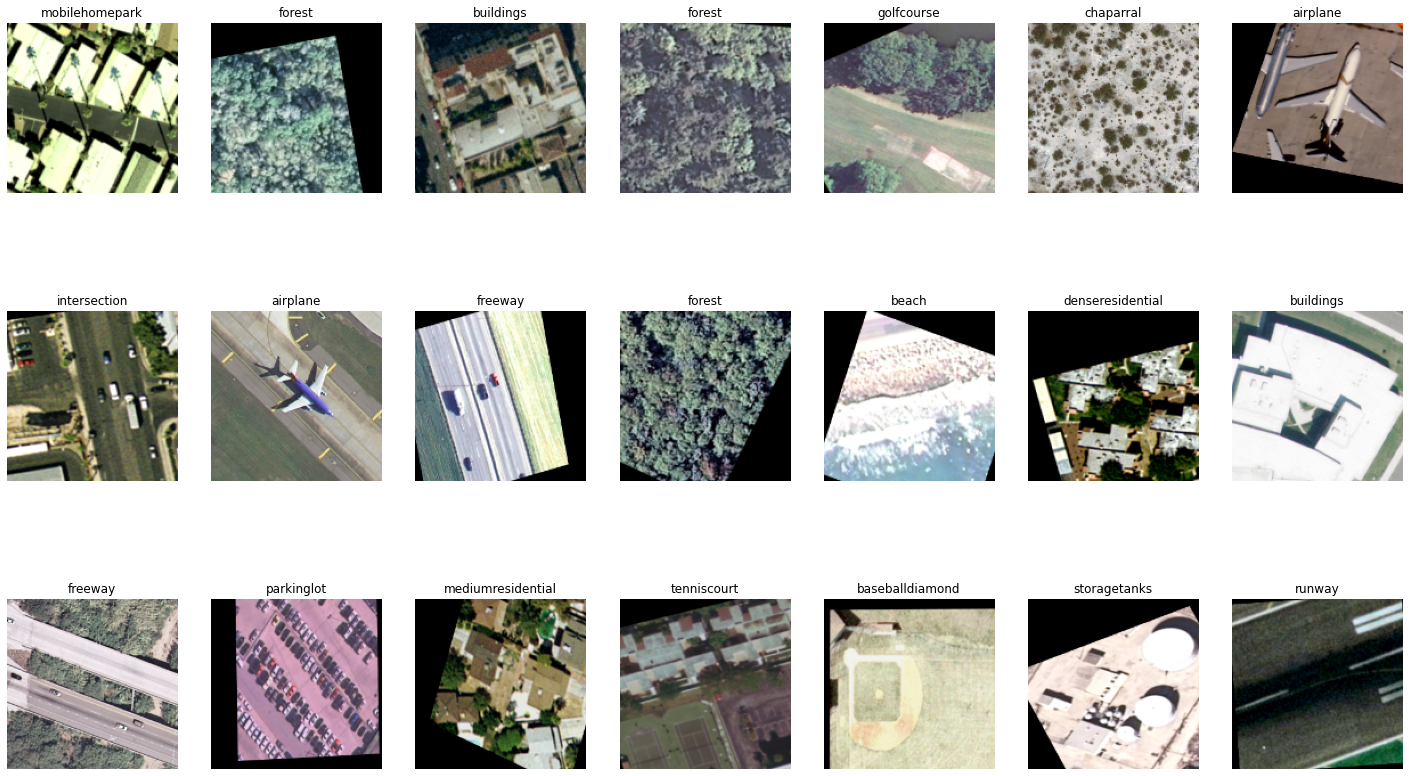

In [ ]:
#display examples of each of the classes
plt.figure(figsize=(25,15))
for i, (image, label) in enumerate(train_ds.take(21)):
    ax = plt.subplot(3, 7, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[int(np.where(label[i]==1)[0])])
    plt.axis("off")

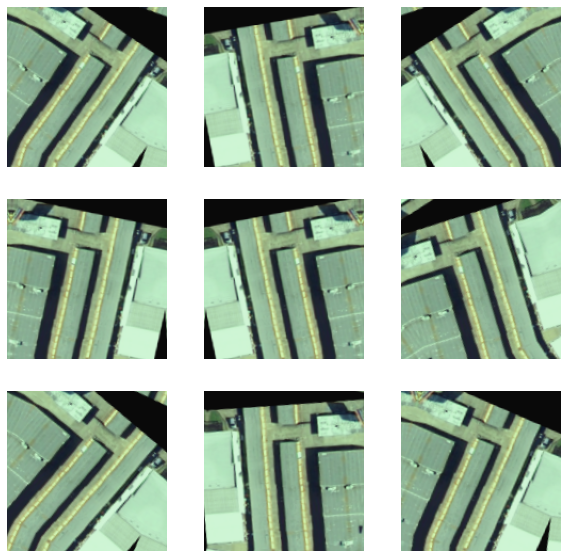

In [ ]:
#Augment images via flips & rotations
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#apply augmentations
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
#Load base Xception Keras model
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
mean = np.array([127.5] * 3)
var = mean ** 2
norm_layer = keras.layers.Normalization()
# Scale inputs to [-1, +1]
x = norm_layer(x)
#norm_layer.set_weights([mean,var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(21, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              209817

In [ ]:
#Compile model and run 100 rounds of training
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 100
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
263/263 [==============================] - 43s 139ms/step - loss: 7.1800 - categorical_accuracy: 0.2045 - val_loss: 2.4271 - val_categorical_accuracy: 0.2414
Epoch 2/100
263/263 [==============================] - 36s 134ms/step - loss: 2.4173 - categorical_accuracy: 0.2550 - val_loss: 2.1582 - val_categorical_accuracy: 0.3105
Epoch 3/100
263/263 [==============================] - 36s 134ms/step - loss: 2.2348 - categorical_accuracy: 0.2862 - val_loss: 2.0545 - val_categorical_accuracy: 0.3305
Epoch 4/100
263/263 [==============================] - 36s 136ms/step - loss: 2.1235 - categorical_accuracy: 0.3182 - val_loss: 1.9446 - val_categorical_accuracy: 0.3733
Epoch 5/100
263/263 [==============================] - 36s 136ms/step - loss: 2.0600 - categorical_accuracy: 0.3284 - val_loss: 1.8960 - val_categorical_accuracy: 0.3743
Epoch 6/100
263/263 [==============================] - 37s 140ms/step - loss: 2.0154 - categorical_accuracy: 0.3457 - val_loss: 1.8359 - val_categoric

In [ ]:
#Unfreeze top layer and run 50 more rounds of fine-tuning
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 50
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              209817

In [ ]:
#Save Model
model.save('drive/MyDrive/Land Use Classification/land_use_classifier_v1.h5', save_format='h5')


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
#Load Model
model = tf.keras.models.load_model('my_model2.h5')

In [ ]:
#Confusion matrix,matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#plot loss & accuracy
#ROC curve
#model.predict(x_test[0])
# Make prediction
#preds = model_predict(img, model)
#pred_class = np.argmax(preds, axis=1)
#if pred_class == 0:
#result = 'Not subluxed'
# elif pred_class == 1:
# result = 'Subluxed'
#docker desktop 
predictions = np.array([])
labels =  np.array([])

for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y.numpy()])

predictions[:10]
array([0., 4., 3., 0., 3., 4., 2., 4., 4., 0.])

labels[:10]
array([0., 4., 3., 0., 3., 4., 1., 2., 4., 0.])

m = tf.keras.metrics.Accuracy()
m(labels, predictions).numpy()

NameError: ignored